С этим датасетом вы уж знакомы https://drive.google.com/drive/folders/1nfQZe8OYJNzGYfV8D3bprSzmFQoSkuaN?usp=sharing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
import os 

In [ ]:
directory = '/content/drive/MyDrive/fish'
train_files = []
target_files = []
fish_types = 'Black Sea Sprat'
for file in os.listdir(os.path.join(directory, fish_types)):
    train_files.append(os.path.join(directory, 'Black Sea Sprat', file))
    target_files.append(os.path.join(directory,  'Black Sea Sprat GT', file))

In [ ]:
df = pd.DataFrame({'img' : train_files, 'mask' : target_files})
df.head()

,img,mask
0,/content/drive/MyDrive/fish/Black Sea Sprat/00...,/content/drive/MyDrive/fish/Black Sea Sprat GT...
1,/content/drive/MyDrive/fish/Black Sea Sprat/00...,/content/drive/MyDrive/fish/Black Sea Sprat GT...
2,/content/drive/MyDrive/fish/Black Sea Sprat/00...,/content/drive/MyDrive/fish/Black Sea Sprat GT...
3,/content/drive/MyDrive/fish/Black Sea Sprat/00...,/content/drive/MyDrive/fish/Black Sea Sprat GT...
4,/content/drive/MyDrive/fish/Black Sea Sprat/00...,/content/drive/MyDrive/fish/Black Sea Sprat GT...


In [ ]:
df = df[:200]

In [ ]:
df1 = pd.DataFrame()

In [ ]:
from tqdm import tqdm

In [ ]:
(df['img'][0])

'/content/drive/MyDrive/fish/Black Sea Sprat/00001.png'

In [ ]:
img = []
for ind in tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
    img.append(origImage)
df1['img'] = img

100%|██████████| 200/200 [00:02<00:00, 84.92it/s]


In [ ]:
(df['mask'][0])

'/content/drive/MyDrive/fish/Black Sea Sprat GT/00001.png'

In [ ]:
mask = []
for ind in tqdm(range(len(df['mask']))):
    origImage = cv2.imread(df['mask'][ind])
    #print(origImage)
    origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
    origImage = (origImage ) 
    mask.append(origImage**2)
df1['mask'] = mask

100%|██████████| 200/200 [00:01<00:00, 183.47it/s]


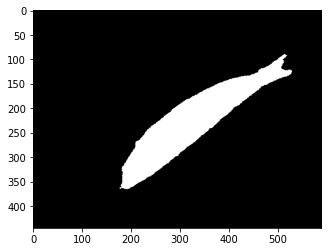

In [ ]:
plt.imshow(mask[0],cmap = "gray")

Сделаем оригинальное изображение черно - белым, чтобы модели приходилось работать с меньшим числом каналов

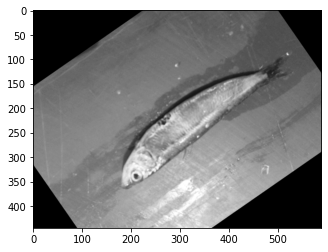

In [ ]:
plt.imshow(df1['img'][0],cmap = "gray")

Сейчас ваш датасет выглядит так, в нем есть матрицы масок, картинок и тд (можно скопировать с лабораторной работы по FCN)
Дальше сама модель (Unet) мы с ней еще ничего не делали

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [ ]:
import torch.nn.functional as F




class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Создадим отдельные переменные (практически не имеет смысла, просто к ним удобнее обращаться) х - изображение у - маска

In [ ]:
x = []
y = []
for ind in tqdm(range(len(df))):
    x.append(df1['img'][ind])
    y.append(df1['mask'][ind])

100%|██████████| 200/200 [00:00<00:00, 24445.89it/s]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 4
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train, y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=batch_size)

testset = MyDataset(X_test, y_test, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size)
#transform = transforms.Compose([transforms.ToTensor()])
'''
dataset = MyDataset(X_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  after removing the cwd from sys.path.


'\ndataset = MyDataset(X_train,y_train, transform=transform)\ntrainloader = DataLoader(dataset, batch_size=4, shuffle=True, sampler=None,\n           batch_sampler=None, num_workers=0, collate_fn=None,\n           pin_memory=False, drop_last=False, timeout=0,\n           worker_init_fn=None)'

In [ ]:
cnt = 0
temp = 0
for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        cnt = i
        if i % 2000 == 1999:
            temp += 1 
cnt,temp

100%|██████████| 40/40 [00:00<00:00, 120.65it/s]


(39, 0)

In [ ]:
net = UNet(1, 2)

In [ ]:
if torch.cuda.is_available():
    net.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
import argparse
import logging
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split

In [ ]:
optimizer = optim.RMSprop(net.parameters(), lr=1e-5, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
import torch
error = []
test_error=[]
for epoch in range(20):
        print('epoch: ------', epoch)
        net.train()
        epoch_loss = 0

        for ind, batch in enumerate(tqdm(trainloader)):
                imgs, true_masks = batch
                '''
                assert imgs.shape[1] == net.n_channels, \
                f'Network has been defined with {net.n_channels} input channels'\
                f'but loaded images have {imgs.shape[1]} channels. Please check that '\
                f'the images are loaded correctly.'''

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()                
                if (ind == 0):
                    print('loss: ', loss)
                    error.append(loss)
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()
        
        
        with torch.no_grad():
            for i, batch in enumerate(tqdm(testloader)):

                X_test_batch, y_pred_batch=batch
                X_test_batch=X_test_batch.to(device=device, dtype=torch.float32)
                y_pred_batch=y_pred_batch.to(device=device, dtype=torch.long)
                y_test_pred=net(X_test_batch)
                test_l=criterion(y_test_pred, y_pred_batch)
                test_error.append(test_l.item())





                #добавьте код, чтобы просматривать ошибки на валидации

epoch: ------ 0


  2%|▎         | 1/40 [00:01<00:44,  1.14s/it]

loss:  tensor(0.0237, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/10 [00:02<?, ?it/s]


NameError: ignored

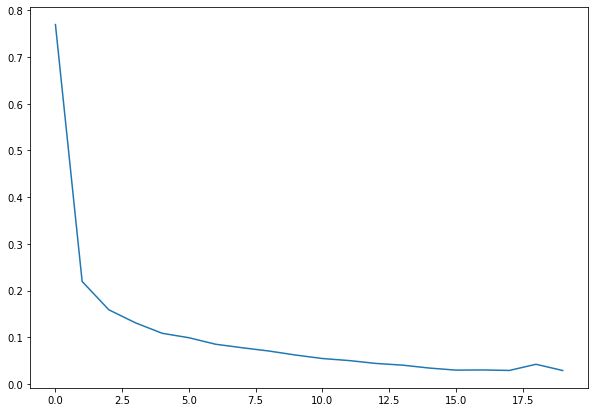

In [ ]:
# на графике должно быть две прямые 
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(error)), error)
plt.show()

In [ ]:
imgs.numpy().argmax()

TypeError: ignored

TypeError: ignored

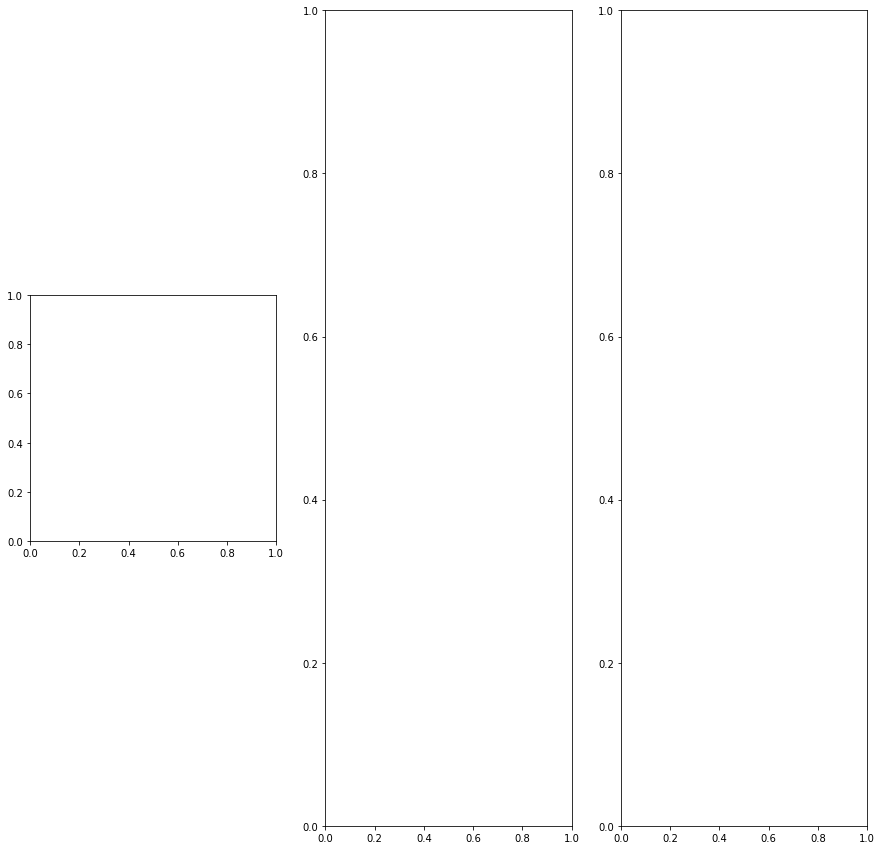

In [ ]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(imgs[im_id])
axes[1].imshow(masks_pred[im_id, ..., 0] > 0.5)
axes[2].imshow(true_masks[im_id, ..., 0])
plt.show()

Задание:
<br> 1 запустите predict на изображениях из TESTLOADERа всего в test датасете должно быть 40 изображений (если вы все сделали верно, то вы получите достаточно хорошие маски и покажите несколько получившихся решений) 
<br> 2 посчитаейте среднюю ошибку для всех изображений из TESTLOADER , метрику выберете самостоятельно 

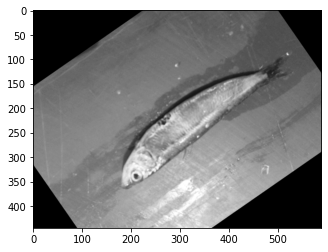

In [ ]:
plt.imshow(df1['img'][0],cmap = "gray")

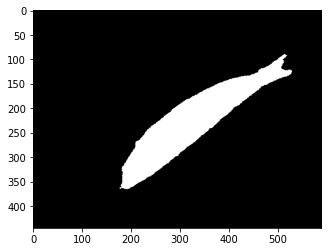

In [ ]:
plt.imshow(mask[0],cmap = "gray")

In [ ]:
true_masks

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')

In [ ]:
masks_pred.shape

torch.Size([4, 2, 445, 590])

In [ ]:
true_masks.shape

torch.Size([4, 445, 590])